In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.tree import export_text, plot_tree
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    brier_score_loss,
    log_loss,
)
import xgboost as xgb

# 00.EDA

In [2]:
PATH = "./dataproject2025.csv"
df = pd.read_csv(PATH).drop(columns=["Unnamed: 0"])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086236 entries, 0 to 1086235
Data columns (total 38 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   issue_d                  1086236 non-null  int64  
 1   loan duration            1086236 non-null  int64  
 2   annual_inc               1086236 non-null  float64
 3   avg_cur_bal              1086236 non-null  float64
 4   bc_open_to_buy           1086236 non-null  float64
 5   bc_util                  1086236 non-null  float64
 6   delinq_2yrs              1086236 non-null  float64
 7   dti                      1086236 non-null  float64
 8   emp_length               1086236 non-null  object 
 9   emp_title                1086236 non-null  object 
 10  fico_range_high          1086236 non-null  float64
 11  funded_amnt              1086236 non-null  float64
 12  grade                    1086236 non-null  object 
 13  home_ownership           1086236 non-null 

Certaines variables sont ordinales, on les retraite dans une fonction définie dans utils.py.

In [3]:
df.head()

,issue_d,loan duration,annual_inc,avg_cur_bal,bc_open_to_buy,bc_util,delinq_2yrs,dti,emp_length,emp_title,...,purpose,revol_bal,revol_util,sub_grade,target,tax_liens,zip_code,Pct_afro_american,Predictions,Predicted probabilities
0,2013,0,39600.0,1379.0,21564.0,16.1,0.0,2.49,2 years,other,...,home_improvement,4136.0,16.1,B2,0,0.0,782,7.388592,0,0.053051
1,2013,0,55000.0,9570.0,16473.0,53.9,0.0,22.87,10+ years,other,...,debt_consolidation,36638.0,61.2,B2,0,0.0,481,9.745456,0,0.084507
2,2013,0,325000.0,53306.0,13901.0,67.1,0.0,18.55,5 years,sales manager,...,debt_consolidation,29581.0,54.6,A3,0,0.0,945,7.542862,0,0.037206
3,2013,0,130000.0,36362.0,3567.0,93.0,0.0,13.03,10+ years,other,...,debt_consolidation,10805.0,67.0,B3,0,0.0,809,6.598132,0,0.061371
4,2013,1,73000.0,24161.0,4853.0,74.7,1.0,23.13,6 years,other,...,debt_consolidation,27003.0,82.8,D5,1,0.0,802,7.058900,1,0.345896


Pour les subgrade, quel est l'ordre ? 

<Axes: xlabel='sub_grade'>

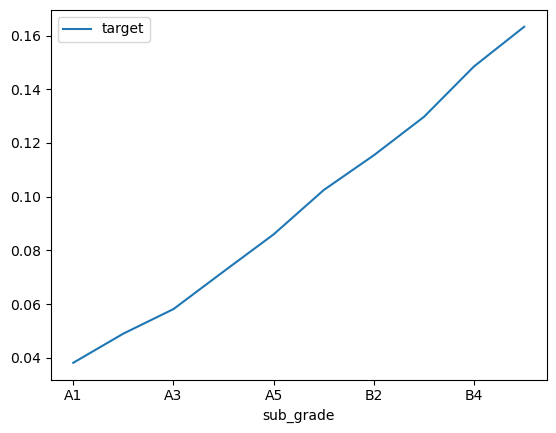

In [4]:
df[["sub_grade", "target"]].groupby("sub_grade").mean()[:10].plot()

Le jeu de données est relativement désequilibré mais les probabilités prédites

In [5]:
df["target"].value_counts()

target
0    857588
1    228648
Name: count, dtype: int64

<Axes: ylabel='Frequency'>

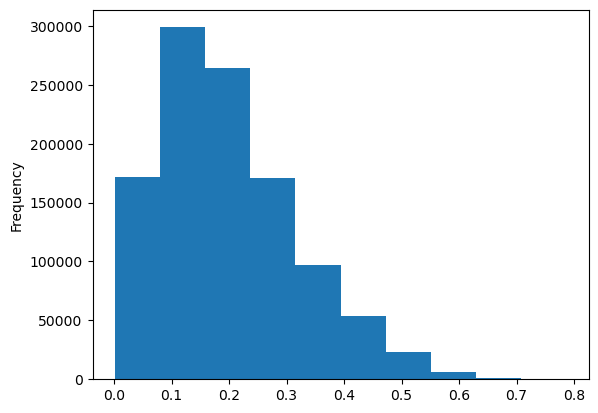

In [6]:
df["Predicted probabilities"].plot(kind="hist")

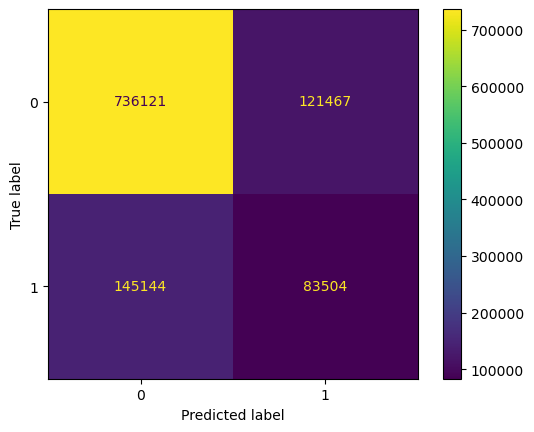

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(df["target"], df["Predictions"])
disp = ConfusionMatrixDisplay(cm)
disp.plot();

# 01. First Surrogate : Linear Regression


On commence par une régression simple, sans encoding particulier. 

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from skrub import TableVectorizer
from joblib import Memory

# to cache the transformed variable
memory = Memory(location=".cache_sklearn", verbose=0)


X = df.drop(columns=["Predicted probabilities", "Predictions", "target"])
y = df["Predicted probabilities"]


model = make_pipeline(
    TableVectorizer(numeric=StandardScaler(), n_jobs=1),
    LinearRegression(),
    memory=memory
)

cv = RepeatedKFold(n_splits=2, n_repeats=1, random_state=42)

cv_model = cross_validate(model, X, y, cv=cv, return_estimator=True, n_jobs=4)


In [9]:
feature_names = cv_model["estimator"][1][0].get_feature_names_out()

coefs = pd.DataFrame(
    [
        cv_model["estimator"][i][-1].coef_ for i in range(len(cv_model["estimator"]))
    ],
    columns=feature_names,
)

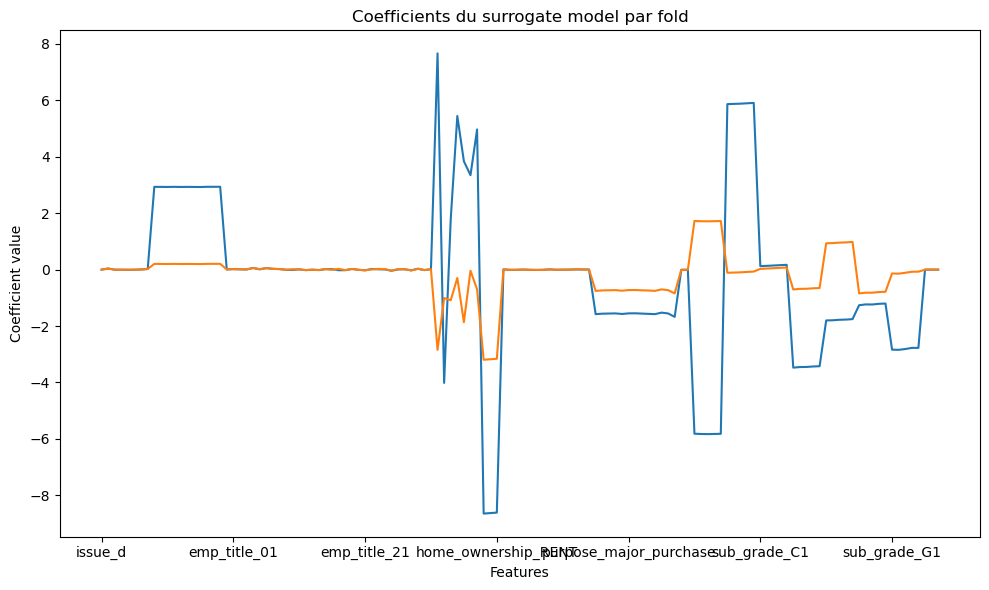

In [10]:
coefs.T.plot(legend=False, figsize=(10, 6))
plt.title("Coefficients du surrogate model par fold")
plt.xlabel("Features")
plt.ylabel("Coefficient value")
plt.tight_layout()
plt.show();

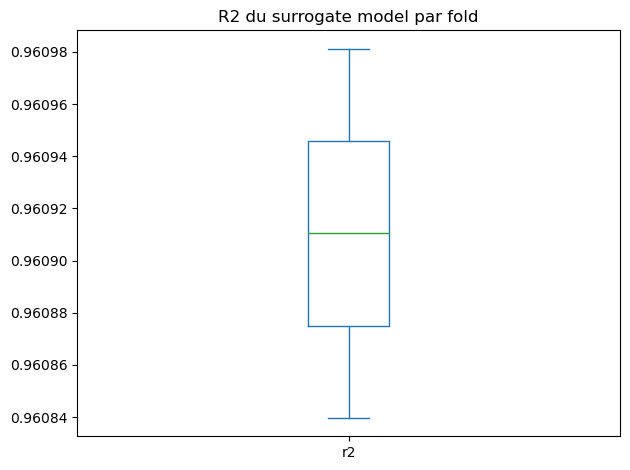

In [11]:
results = pd.DataFrame(cv_model["test_score"], columns=["r2"])
results.plot(kind="box", legend=False)
plt.title("R2 du surrogate model par fold")
plt.tight_layout()
plt.show();